# About

For the final two submission on Kaggle, two different models were used.  

    1. Model 1 (Top Submission) is a Autoencoder with Convolution and Max Pooling Layers to learn local features.
    2. Model 2 (2nd Top Submission) is a Shallow Autoencoder with L1 Regularisation to learn sparse features.  

**Note:** 
* For all models, they are run three times each with differnet weights initialized to accurately evaluate the model architecture. This ensures that the results of the model is not largely affected by the weights initialized, allowing comparison across different architectures.

# Instructions to Run Codes  

    1. To ensure reproducibility of results, the environment python hash seed was set. Additionally seeds were set for multiple pacakges (e.g. random, numpy and tensorflow) to ensure that all random initialization of values can be reproduced.

    2. Packages and dependencies to install can be found in `A0171817B-requirements.txt`

    3. The codes below can be run in choronological order to obtain results. Do remember to change the paths/directories to read in the train and test images as well as the directory to write out the csv predictions file


# Layout of Notebook

### Model 1: Autoencoder with Convolution-Pooling Layers (Top Submission)
        1. Set Seed for Reproducibility
        2. Import Relevant Packages
        [-------- Data Preprocessing ---------]
        3. Load in Data
        4. Splitting Dataset
        [-------- Feature Engineering & Prediction Validation ---------]
        5. Autoencoder Training
            * Run 1
            * Run 2
            * Run 3
        6. Quantify Model Performance using Average AUC-ROC Score of all three runs 
        [-------- Generating .csv ---------]
        7. Get best model of 3 randomly initialized weights to predict Kaggle Competition Test Data
        
### Model 2: Shallow Autoencoder with L1 Regularization (2nd Top Submission)
        1. Set Seed for Reproducibility
        2. Import Relevant Packages
        [-------- Data Preprocessing ---------]
        3. Load in Data
        4. Splitting Dataset
        [-------- Feature Engineering & Prediction Validation ---------]
        5. Autoencoder Training
            * Run 1
            * Run 2
            * Run 3
        6. Quantify Model Performance using Average AUC-ROC Score of all three runs 
        [-------- Generating .csv ---------]
        7. Get best model of 3 randomly initialized weights to predict Kaggle Competition Test Data

***

# Model 1: Autoencoder with Convolution-Pooling Layers

## 1. Set Seed for Reproducibility

In [1]:
%env PYTHONHASHSEED=2

env: PYTHONHASHSEED=2


In [2]:
# Setting Seed - https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds 

seed_value = 60

import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

# configure a new global tensorflow session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## 2. Import Relevant Packages

In [3]:
import cv2                
from tqdm import tqdm
import itertools

# Data Reading and Writing
import pandas as pd 

# Data Visualisation
import seaborn as sns; sns.set(font_scale=1.4)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Splitting dataset 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle           

# Performance metrics 
from sklearn.metrics import roc_auc_score

# Import Keras
import keras

# Data Processing/ Feature Engineering
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical #convert to one-hot-encoding

# Model building
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization

# Optimizer
from keras.optimizers import Adam, RMSprop, SGD, Adadelta

# Regularizing/Prevent Overfitting
from keras import regularizers 
from keras.layers import Dropout

# Stop training
from keras.callbacks import EarlyStopping

## 3. Load in Data
* remember to change the file path/directory here to read in the train and test images

In [4]:
# Load in Training data and Labels

images = []

folder = '../../train_images/train_images/'
labels = pd.read_csv('../../train_images/train.csv')['label'].values
IMAGE_SIZE = (28, 28)

# Iterate through each image in our folder
for i in range(6427):
    file = str(i) + '.jpg'
    # Get the path name of the image
    img_path = folder + file

    # Open and resize the img
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, IMAGE_SIZE) 

    # Append the image and its corresponding label to the output
    images.append(image)

images = np.array(images, dtype = 'float32')
labels = np.array(labels, dtype = 'float32')   

# normalized values to 0-1 since the image pixel values range from 0 to 255
# images are of 28 x 28 dimension
X = (images.flatten()/255.0).reshape(-1, 28,28,1)

# one-hot-encode classes
Y = to_categorical(labels, num_classes=2)   

In [5]:
# Loading in Kaggle Test Data

folder = '../../test_images/test_images/'
images = []
IMAGE_SIZE = (28, 28)

# Iterate through each image in our folder
for i in range(1070):
    file = str(i) + '.jpg'
    img_path = folder + file

    # Open and resize the img
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, IMAGE_SIZE) 
    
    images.append(image)

images = np.array(images, dtype = 'float32')              

# normalized values to 0-1 since the image pixel values range from 0 to 255
# images are of 28 x 28 dimension
kaggle_test = (images.flatten()/255.0).reshape(-1, 28,28,1)


## 4. Splitting Dataset 
* The dataset is split into train-validation and test in the ratio of 9:1
* For the train-validation set, the normal labelled data is further split into the X_normal_train and X_normal_val in the ratio of 9:1
* Eventually, we have the following:
    * Training Data: Normal Data
    * Validation Data: Normal Data + Anomaly Data
    * Testing Data: Normal Data + Anomaly Data

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size=0.3, 
                                                          random_state=seed_value, 
                                                          shuffle=True, 
                                                          stratify=Y)


X_normal = X_train[Y_train == 0]
X_anomaly_val = X_train[Y_train == 1]

X_normal_train, X_normal_val = train_test_split(X_normal, test_size=0.1, random_state=42)


In [7]:
print('Normal Data Training: ', X_normal_train.shape)
print('Normal Data Validation: ', X_normal_val.shape)
print('Anomaly Data Validation: ', X_anomaly_val.shape)
print('Test Data: ', X_test.shape)

Normal Data Training:  (3730, 28, 28, 1)
Normal Data Validation:  (415, 28, 28, 1)
Anomaly Data Validation:  (353, 28, 28, 1)
Test Data:  (1929, 28, 28, 1)


## 5. Autoencoder training

As mentioned above, the model with the following architecture will be run three times with different weights initialized. 
* The AUC scores of each run will be averaged at the end to evaluate the model architecutre. 
* This helps to acccurately evaluate the model's architecture for comparison across the different model architecture experimented as the results obtained will not be solely dependent on weights initialized.

In [9]:
# Size of input images
input_img = Input(shape = (28, 28, 1))   

In [10]:
def encoder(input_img):
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = Dropout(0.4)(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)   
    return encoded

In [11]:
def decoder(encoded):
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    return decoded

In [8]:
# Early Stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

### Run 1:

In [12]:
# Initialize Data Generator for Data Augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_normal_train)

In [13]:
autoencoder_es = Model(input_img, decoder(encoder(input_img)))

In [14]:
autoencoder_es.compile(loss='binary_crossentropy', optimizer='adam')

In [16]:
# Autoencoder model is trained with data augmentation generated with each batch run
history = autoencoder_es.fit_generator(datagen.flow(X_normal_train, X_normal_train, batch_size=60),
                                   epochs = 50, 
                                   shuffle=True,
                                   validation_data = (X_normal_val, X_normal_val),
                                   callbacks=[es])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
63/63 [==============================] - 18s 291ms/step - loss: 0.3633 - val_loss: 0.2645
Epoch 2/50
63/63 [==============================] - 18s 284ms/step - loss: 0.2437 - val_loss: 0.2254
Epoch 3/50
63/63 [==============================] - 18s 283ms/step - loss: 0.2223 - val_loss: 0.2163
Epoch 4/50
63/63 [==============================] - 18s 281ms/step - loss: 0.2106 - val_loss: 0.2021
Epoch 5/50
63/63 [==============================] - 18s 282ms/step - loss: 0.2040 - val_loss: 0.2049
Epoch 6/50
63/63 [==============================] - 18s 287ms/step - loss: 0.2011 - val_loss: 0.1915
Epoch 7/50
63/63 [==============================] - 19s 303ms/step - loss: 0.1962 - val_loss: 0.1918
Epoch 8/50
63/63 [==============================] - 17s 278ms/step - loss: 0.1943 - val_loss: 0.1843
Epoch 9/50
63/63 [==============================] - 17s 277ms/step - loss: 0.1907 - val_loss: 0.1896
Epoch 10/50
63/

[(0.1308945059776306, 0.435969865322113)]

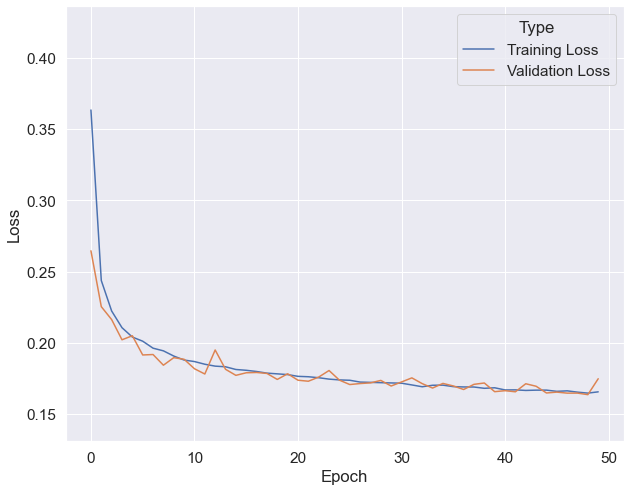

In [17]:
# Visualize the training and validation loss

losses = history.history['loss'] + history.history['val_loss']
types = ['Training Loss'] * len(history.history['loss']) + ['Validation Loss'] * len(history.history['val_loss'])
epoches = history.epoch + history.epoch
df_losses = pd.DataFrame({'Loss': losses, 'Epoch':epoches, 'Type': types})

plt.figure(figsize=(10, 8))
ax = sns.lineplot(data=df_losses, x='Epoch', y='Loss', hue='Type')
ax.set(ylim=(min(df_losses['Loss']) * 0.8, max(df_losses['Loss']) * 1.2))

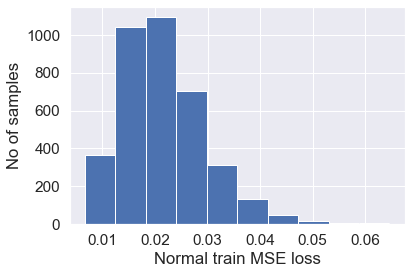

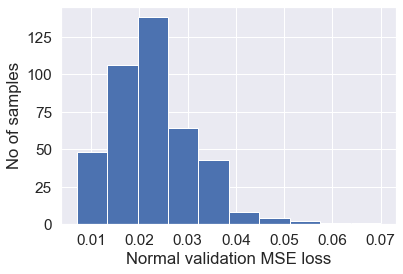

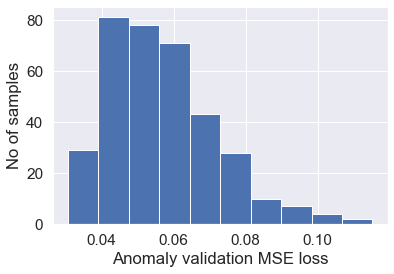

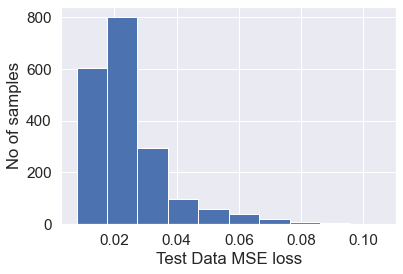

AUC of Test Data:  0.9903232294638667


In [18]:
# Visualize the distribution of Mean Square Error

## MSE of Normal Training Data
model = autoencoder_es
errors_normal_train = []
x_normal_train_pred = model.predict(X_normal_train)
for i in range(len(X_normal_train)):
    errors_normal_train.append(np.mean((x_normal_train_pred[i] - X_normal_train[i])**2))

    
## MSE of Normal Validation Data
errors_normal_val = []
x_normal_val_pred = model.predict(X_normal_val)
for i in range(len(X_normal_val)):
    errors_normal_val.append(np.mean((x_normal_val_pred[i] - X_normal_val[i])**2))

    
## MSE of Anomaly Validation Data
errors_anomaly_val = []
x_anomaly_val_pred = model.predict(X_anomaly_val)
for i in range(len(X_anomaly_val)):
    errors_anomaly_val.append(np.mean((x_anomaly_val_pred[i] - X_anomaly_val[i])**2))

    
## MSE of Normal & Anomaly Test Data
errors_test = []
x_test_pred = model.predict(X_test)
for i in range(len(X_test)):
    errors_test.append(np.mean((x_test_pred[i] - X_test[i])**2))


## Plot error distribution
plt.hist(errors_normal_train, bins=10)
plt.xlabel("Normal train MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_normal_val, bins=10)
plt.xlabel("Normal validation MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_anomaly_val, bins=10)
plt.xlabel("Anomaly validation MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_test, bins=10)
plt.xlabel("Test Data MSE loss")
plt.ylabel("No of samples")
plt.show()

from sklearn.metrics import roc_auc_score
print('AUC of Test Data: ', roc_auc_score(Y_test, errors_test))

errors_test_1 = errors_test

### Run 2: 

In [19]:
# Initialize Data Generator for Data Augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_normal_train)

In [20]:
autoencoder_es_2 = Model(input_img, decoder(encoder(input_img)))

In [21]:
autoencoder_es_2.compile(loss='binary_crossentropy', optimizer='adam')

In [23]:
# Autoencoder model is trained with data augmentation generated with each batch run

history = autoencoder_es_2.fit_generator(datagen.flow(X_normal_train, X_normal_train, batch_size=60),
                                   epochs = 50, 
                                   shuffle=True,
                                   validation_data = (X_normal_val, X_normal_val),
                                   callbacks=[es])

Epoch 1/50
63/63 [==============================] - 18s 285ms/step - loss: 0.3856 - val_loss: 0.2636
Epoch 2/50
63/63 [==============================] - 17s 277ms/step - loss: 0.2460 - val_loss: 0.2307
Epoch 3/50
63/63 [==============================] - 18s 283ms/step - loss: 0.2247 - val_loss: 0.2123
Epoch 4/50
63/63 [==============================] - 18s 279ms/step - loss: 0.2138 - val_loss: 0.2085
Epoch 5/50
63/63 [==============================] - 18s 279ms/step - loss: 0.2067 - val_loss: 0.2021
Epoch 6/50
63/63 [==============================] - 17s 277ms/step - loss: 0.2026 - val_loss: 0.1937
Epoch 7/50
63/63 [==============================] - 18s 281ms/step - loss: 0.1977 - val_loss: 0.1949
Epoch 8/50
63/63 [==============================] - 17s 277ms/step - loss: 0.1946 - val_loss: 0.1883
Epoch 9/50
63/63 [==============================] - 18s 278ms/step - loss: 0.1913 - val_loss: 0.1874
Epoch 10/50
63/63 [==============================] - 17s 277ms/step - loss: 0.1909 - val_lo

[(0.14121626615524294, 0.46276001930236815)]

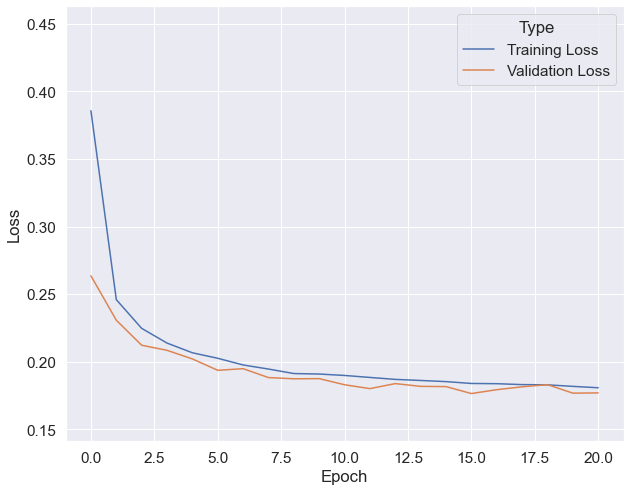

In [24]:
# Visualize the training and validation loss

losses = history.history['loss'] + history.history['val_loss']
types = ['Training Loss'] * len(history.history['loss']) + ['Validation Loss'] * len(history.history['val_loss'])
epoches = history.epoch + history.epoch
df_losses = pd.DataFrame({'Loss': losses, 'Epoch':epoches, 'Type': types})

plt.figure(figsize=(10, 8))
ax = sns.lineplot(data=df_losses, x='Epoch', y='Loss', hue='Type')
ax.set(ylim=(min(df_losses['Loss']) * 0.8, max(df_losses['Loss']) * 1.2))

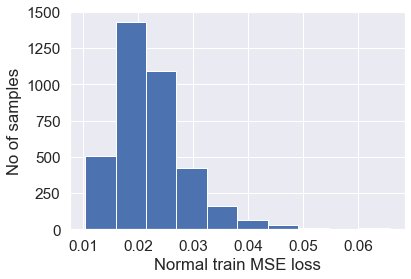

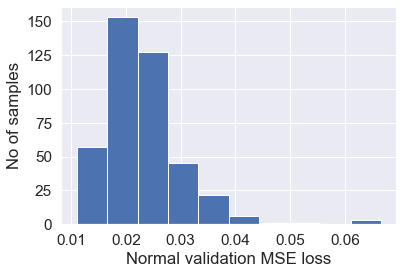

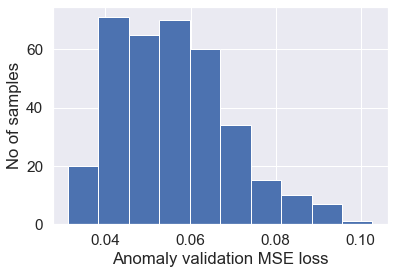

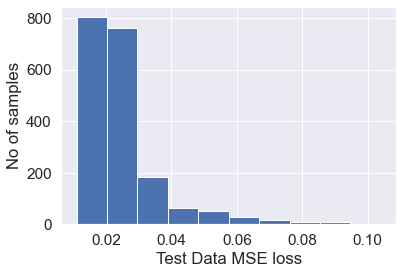

AUC of Test Data:  0.993273191844397


In [25]:
# Visualize the distribution of Mean Square Error 

## MSE of Normal Training Data
model = autoencoder_es_2
errors_normal_train = []
x_normal_train_pred = model.predict(X_normal_train)
for i in range(len(X_normal_train)):
    errors_normal_train.append(np.mean((x_normal_train_pred[i] - X_normal_train[i])**2))


## MSE of Normal Validation Data
errors_normal_val = []
x_normal_val_pred = model.predict(X_normal_val)
for i in range(len(X_normal_val)):
    errors_normal_val.append(np.mean((x_normal_val_pred[i] - X_normal_val[i])**2))

    
## MSE of Anomaly Validation Data
errors_anomaly_val = []
x_anomaly_val_pred = model.predict(X_anomaly_val)
for i in range(len(X_anomaly_val)):
    errors_anomaly_val.append(np.mean((x_anomaly_val_pred[i] - X_anomaly_val[i])**2))
    
    
## MSE of Normal & Anomaly Test Data    
errors_test = []
x_test_pred = model.predict(X_test)
for i in range(len(X_test)):
    errors_test.append(np.mean((x_test_pred[i] - X_test[i])**2))


## Plot error distribution
plt.hist(errors_normal_train, bins=10)
plt.xlabel("Normal train MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_normal_val, bins=10)
plt.xlabel("Normal validation MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_anomaly_val, bins=10)
plt.xlabel("Anomaly validation MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_test, bins=10)
plt.xlabel("Test Data MSE loss")
plt.ylabel("No of samples")
plt.show()

from sklearn.metrics import roc_auc_score
print('AUC of Test Data: ', roc_auc_score(Y_test, errors_test))

errors_test_2 = errors_test

### Run 3:

In [26]:
# Initialize Data Generator for Data Augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_normal_train)

In [27]:
autoencoder_es_3 = Model(input_img, decoder(encoder(input_img)))

In [28]:
autoencoder_es_3.compile(loss='binary_crossentropy', optimizer='adam')

In [30]:
# Autoencoder model is trained with data augmentation generated with each batch run

history = autoencoder_es_3.fit_generator(datagen.flow(X_normal_train, X_normal_train, batch_size=60),
                                   epochs = 50, 
                                   shuffle=True,
                                   validation_data = (X_normal_val, X_normal_val),
                                   callbacks=[es])

Epoch 1/50
63/63 [==============================] - 18s 286ms/step - loss: 0.3703 - val_loss: 0.2617
Epoch 2/50
63/63 [==============================] - 17s 276ms/step - loss: 0.2446 - val_loss: 0.2274
Epoch 3/50
63/63 [==============================] - 17s 276ms/step - loss: 0.2252 - val_loss: 0.2208
Epoch 4/50
63/63 [==============================] - 17s 275ms/step - loss: 0.2133 - val_loss: 0.2173
Epoch 5/50
63/63 [==============================] - 17s 277ms/step - loss: 0.2060 - val_loss: 0.2081
Epoch 6/50
63/63 [==============================] - 18s 279ms/step - loss: 0.2003 - val_loss: 0.1941
Epoch 7/50
63/63 [==============================] - 17s 275ms/step - loss: 0.1978 - val_loss: 0.1935
Epoch 8/50
63/63 [==============================] - 17s 277ms/step - loss: 0.1939 - val_loss: 0.1911
Epoch 9/50
63/63 [==============================] - 17s 276ms/step - loss: 0.1913 - val_loss: 0.1920
Epoch 10/50
63/63 [==============================] - 17s 274ms/step - loss: 0.1908 - val_lo

[(0.13089252710342408, 0.4443624973297119)]

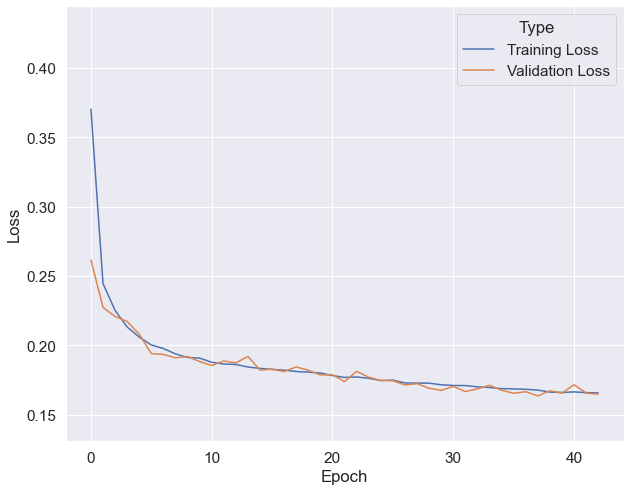

In [31]:
# Visualize the training and validation loss

losses = history.history['loss'] + history.history['val_loss']
types = ['Training Loss'] * len(history.history['loss']) + ['Validation Loss'] * len(history.history['val_loss'])
epoches = history.epoch + history.epoch
df_losses = pd.DataFrame({'Loss': losses, 'Epoch':epoches, 'Type': types})

plt.figure(figsize=(10, 8))
ax = sns.lineplot(data=df_losses, x='Epoch', y='Loss', hue='Type')
ax.set(ylim=(min(df_losses['Loss']) * 0.8, max(df_losses['Loss']) * 1.2))

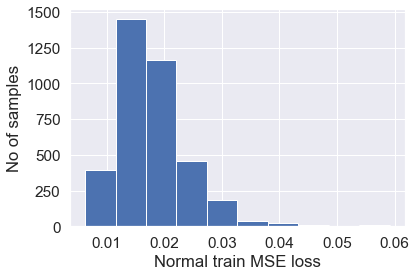

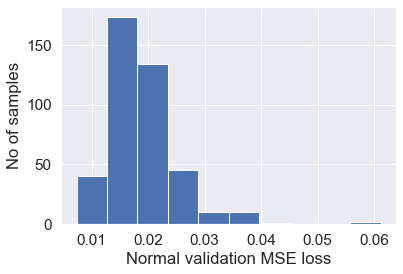

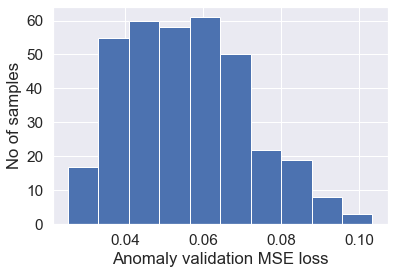

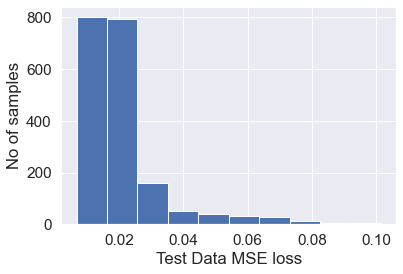

AUC of Test Data:  0.9962790247245585


In [32]:
# Visualize the distribution of Mean Square Error 

## MSE of Normal Training Data
model = autoencoder_es_3
errors_normal_train = []
x_normal_train_pred = model.predict(X_normal_train)
for i in range(len(X_normal_train)):
    errors_normal_train.append(np.mean((x_normal_train_pred[i] - X_normal_train[i])**2))


## MSE of Normal Validation Data
errors_normal_val = []
x_normal_val_pred = model.predict(X_normal_val)
for i in range(len(X_normal_val)):
    errors_normal_val.append(np.mean((x_normal_val_pred[i] - X_normal_val[i])**2))

    
## MSE of Anomaly Validation Data
errors_anomaly_val = []
x_anomaly_val_pred = model.predict(X_anomaly_val)
for i in range(len(X_anomaly_val)):
    errors_anomaly_val.append(np.mean((x_anomaly_val_pred[i] - X_anomaly_val[i])**2))

    
## MSE of Normal & Anomaly Test Data
errors_test = []
x_test_pred = model.predict(X_test)
for i in range(len(X_test)):
    errors_test.append(np.mean((x_test_pred[i] - X_test[i])**2))


## Plot error distribution
plt.hist(errors_normal_train, bins=10)
plt.xlabel("Normal train MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_normal_val, bins=10)
plt.xlabel("Normal validation MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_anomaly_val, bins=10)
plt.xlabel("Anomaly validation MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_test, bins=10)
plt.xlabel("Test Data MSE loss")
plt.ylabel("No of samples")
plt.show()

from sklearn.metrics import roc_auc_score
print('AUC of Test Data: ', roc_auc_score(Y_test, errors_test))

errors_test_3 = errors_test

## 6. Quantify Model Performance using Average AUC-ROC Score of all three runs 
* Hence, we see that the average AUC-ROC score for the Autoencoder model using Convolution and Max Pooling layers is 0.9932918

In [36]:
avg_auc = np.mean([roc_auc_score(Y_test, errors_test_1), roc_auc_score(Y_test, errors_test_2), roc_auc_score(Y_test, errors_test_3)])
print('Average AUC ROC score across all 3 runs: ', avg_auc)

Average AUC ROC score across all 3 runs: 0.993291815344274


## 7. Get best model of 3 randomly initialized weights to predict Kaggle Competition Test Data

* As we see that the AUC of errors of test data from prediction of the third run is the highest, we will use the third model initilized weights to predict kaggle test data

In [33]:
print('Model 1 Test AUC', roc_auc_score(Y_test, errors_test_1))
print('Model 2 Test AUC', roc_auc_score(Y_test, errors_test_2))
print('Model 3 Test AUC', roc_auc_score(Y_test, errors_test_3))

Model 1 Test AUC 0.9903232294638667
Model 2 Test AUC 0.993273191844397
Model 3 Test AUC 0.9962790247245585


In [35]:
model = autoencoder_es_3

error_kaggle = []
kaggle_pred = model.predict(kaggle_test)
for i in range(len(kaggle_test)):
    error_kaggle.append(np.mean((kaggle_pred[i] - kaggle_test[i])**2))
    
predict_output = pd.Series(error_kaggle, name='target')
predict_output = pd.concat([pd.Series(range(0,1070),name='id'), predict_output], axis=1)
# predict_output.to_csv("C:/Users/Asus/Desktop/Uni School Work/Year 4/Sem 1/BT4012/bt4012-in-class-competition/anomalydetection_autoencoder/convo_autoencoder_es_predictions.csv", index=False)

***

# Model 2: Shallow Autoencoder with L1 Regularization

## 1. Set Seed for Reproducibility

In [20]:
%env PYTHONHASHSEED=0

env: PYTHONHASHSEED=0


In [21]:
# Setting Seed - https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds 

seed_value = 42

import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

# configure a new global tensorflow session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## 2. Import Relevant Packages

In [22]:
import cv2                
from tqdm import tqdm
import itertools

# Data Reading and Writing
import pandas as pd 

# Data Visualisation
import seaborn as sns; sns.set(font_scale=1.4)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Splitting dataset 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle           

# Performance metrics 
from sklearn.metrics import roc_auc_score

# Import Keras
import keras

# Data Processing/ Feature Engineering
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical #convert to one-hot-encoding

# Model building
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization

# Optimizer
from keras.optimizers import Adam, RMSprop, SGD, Adadelta

# Regularizing/Prevent Overfitting
from keras import regularizers 
from keras.layers import Dropout

# Stop training
from keras.callbacks import EarlyStopping

## 3. Load in Data

In [23]:
# Load in Training data and Labels

images = []

folder = '../train_images/train_images/'
labels = pd.read_csv('../train_images/train.csv')['label'].values
IMAGE_SIZE = (28, 28)

# Iterate through each image in our folder
for i in range(6427):
    file = str(i) + '.jpg'
    # Get the path name of the image
    img_path = folder + file

    # Open and resize the img
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, IMAGE_SIZE) 

    # Append the image and its corresponding label to the output
    images.append(image)

images = np.array(images, dtype = 'float32')
labels = np.array(labels, dtype = 'float32')   

# normalized values to 0-1 since the image pixel values range from 0 to 255
# images are of 28 x 28 dimension
X = (images.flatten()/255.0).reshape(-1, 28, 28).reshape(len(images), -1)
# one-hot-encode classes
Y = to_categorical(labels, num_classes=2)   

In [24]:
# Loading in Kaggle Test Data

folder = '../test_images/test_images/'
images = []
IMAGE_SIZE = (28, 28)

# Iterate through each image in our folder
for i in range(1070):
    file = str(i) + '.jpg'
    img_path = folder + file

    # Open and resize the img
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, IMAGE_SIZE) 
    
    images.append(image)

images = np.array(images, dtype = 'float32')              # changing to float32

# normalized values to 0-1 since the image pixel values range from 0 to 255
# images are of 28 x 28 dimension
kaggle_test = (images.flatten()/255.0).reshape(-1, 28,28,1).reshape(1070,-1)  


## 4. Splitting Dataset 
* The dataset is split into train-validation and test in the ratio of 9:1
* For the train-validation set, the normal labelled data is further split into the X_normal_train and X_normal_val in the ratio of 9:1
* Eventually, we have the following:
    * Training Data: Normal Data
    * Validation Data: Normal Data + Anomaly Data
    * Testing Data: Normal Data + Anomaly Data

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size=0.3, 
                                                          random_state=seed_value, 
                                                          shuffle=True, 
                                                          stratify=Y)


X_normal = X_train[Y_train == 0]
X_anomaly_val = X_train[Y_train == 1]

X_normal_train, X_normal_val = train_test_split(X_normal, test_size=0.1, random_state=42)


In [26]:
print('Normal Data Training: ', X_normal_train.shape)
print('Normal Data Validation: ', X_normal_val.shape)
print('Anomaly Data Validation: ', X_anomaly_val.shape)
print('Test Data: ', X_test.shape)

Normal Data Training:  (3730, 784)
Normal Data Validation:  (415, 784)
Anomaly Data Validation:  (353, 784)
Test Data:  (1929, 784)


## 5. Autoencoder training

As mentioned above, the model with the following architecture will be run three times with different weights initialized. 
* The AUC scores of each run will be averaged at the end to evaluate the model architecutre. 
* This helps to acccurately evaluate the model's architecture for comparison across the models experimented as the results obtained will not be solely dependent on weights initialized.

In [27]:
# Shallow Autoencoder
def build_shallow_autoencoder(input_dim=784, encoding_dim=30):
    input_img = Input(shape=(input_dim,))
    encoded = encoder(input_img, encoding_dim)
    decoded = decoder(encoded, input_dim)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

def encoder(input_img, encoding_dim):
    encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_img)
    return encoded

def decoder(encoded, input_dim):
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    return decoded


In [28]:
# Early Stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

### Run 1:

In [29]:
shallow_autoencoder = build_shallow_autoencoder(input_dim=784, encoding_dim=30)

In [30]:
# Start the training process
history = shallow_autoencoder.fit(X_normal_train, X_normal_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_normal_val, X_normal_val),
                callbacks=[es])

Epoch 1/50
15/15 [==============================] - 0s 32ms/step - loss: 0.6540 - val_loss: 0.5576
Epoch 2/50
15/15 [==============================] - 0s 12ms/step - loss: 0.4458 - val_loss: 0.3425
Epoch 3/50
15/15 [==============================] - 0s 12ms/step - loss: 0.3129 - val_loss: 0.2943
Epoch 4/50
15/15 [==============================] - 0s 13ms/step - loss: 0.2879 - val_loss: 0.2809
Epoch 5/50
15/15 [==============================] - 0s 13ms/step - loss: 0.2748 - val_loss: 0.2670
Epoch 6/50
15/15 [==============================] - 0s 13ms/step - loss: 0.2605 - val_loss: 0.2533
Epoch 7/50
15/15 [==============================] - 0s 13ms/step - loss: 0.2484 - val_loss: 0.2433
Epoch 8/50
15/15 [==============================] - 0s 19ms/step - loss: 0.2400 - val_loss: 0.2363
Epoch 9/50
15/15 [==============================] - 0s 24ms/step - loss: 0.2338 - val_loss: 0.2306
Epoch 10/50
15/15 [==============================] - 0s 26ms/step - loss: 0.2280 - val_loss: 0.2247
Epoch 11/

[(0.1297664999961853, 0.784778380393982)]

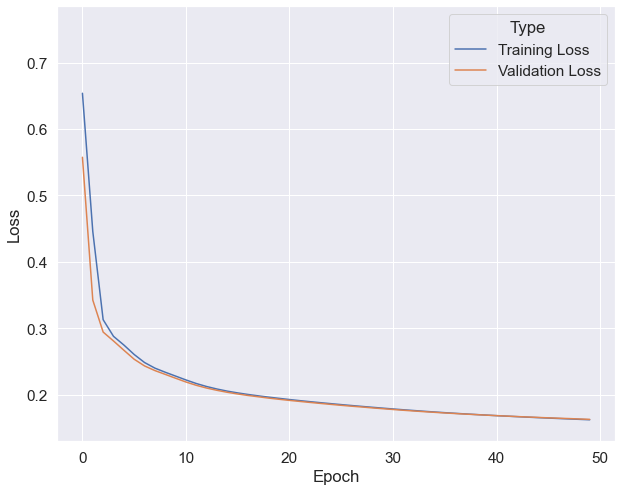

In [31]:
# Visualize the training and validation loss

losses = history.history['loss'] + history.history['val_loss']
types = ['Training Loss'] * len(history.history['loss']) + ['Validation Loss'] * len(history.history['val_loss'])
epoches = history.epoch + history.epoch
df_losses = pd.DataFrame({'Loss': losses, 'Epoch':epoches, 'Type': types})

plt.figure(figsize=(10, 8))
ax = sns.lineplot(data=df_losses, x='Epoch', y='Loss', hue='Type')
ax.set(ylim=(min(df_losses['Loss']) * 0.8, max(df_losses['Loss']) * 1.2))

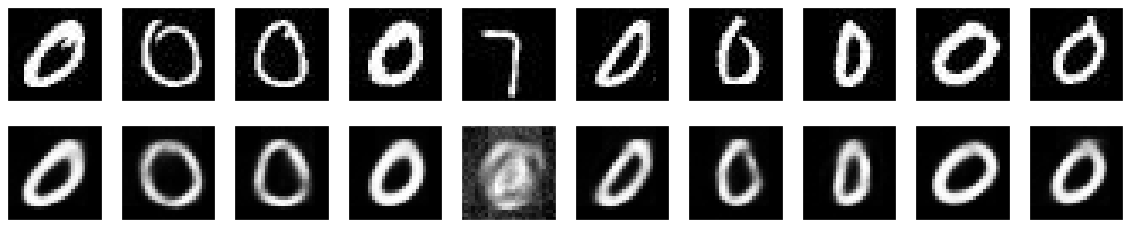

In [32]:
# Visualize the autoencoder predictions vs original images

shallow_decoded_imgs = shallow_autoencoder.predict(X_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(shallow_decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

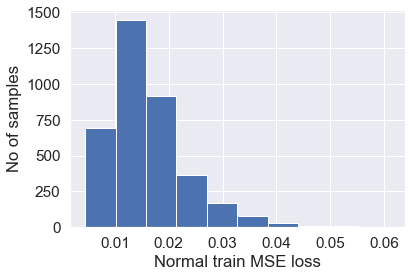

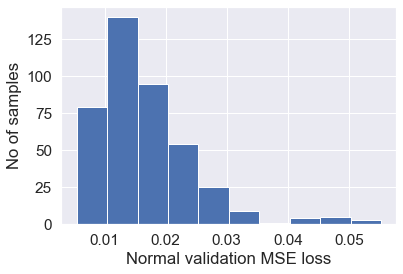

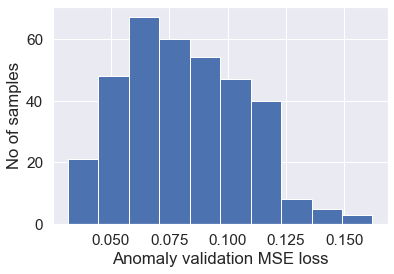

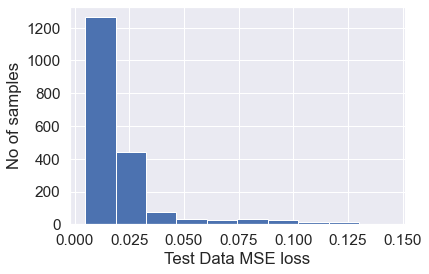

AUC of Test Data:  0.9984914965099562


In [33]:
# Visualize the distribution of Mean Square Error

model = shallow_autoencoder


## MSE of Normal Training Data
errors_normal_train = []
x_normal_train_pred = model.predict(X_normal_train)
for i in range(len(X_normal_train)):
    errors_normal_train.append(np.mean((x_normal_train_pred[i] - X_normal_train[i])**2))


## MSE of Normal Validation Data
errors_normal_val = []
x_normal_val_pred = model.predict(X_normal_val)
for i in range(len(X_normal_val)):
    errors_normal_val.append(np.mean((x_normal_val_pred[i] - X_normal_val[i])**2))


## MSE of Anomaly Validation Data  
errors_anomaly_val = []
x_anomaly_val_pred = model.predict(X_anomaly_val)
for i in range(len(X_anomaly_val)):
    errors_anomaly_val.append(np.mean((x_anomaly_val_pred[i] - X_anomaly_val[i])**2))

    
## MSE of Normal & Anomaly Test Data
errors_test = []
x_test_pred = model.predict(X_test)
for i in range(len(X_test)):
    errors_test.append(np.mean((x_test_pred[i] - X_test[i])**2))


## Plot error distribution
plt.hist(errors_normal_train, bins=10)
plt.xlabel("Normal train MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_normal_val, bins=10)
plt.xlabel("Normal validation MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_anomaly_val, bins=10)
plt.xlabel("Anomaly validation MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_test, bins=10)
plt.xlabel("Test Data MSE loss")
plt.ylabel("No of samples")
plt.show()

from sklearn.metrics import roc_auc_score
print('AUC of Test Data: ', roc_auc_score(Y_test, errors_test))

errors_test_1 = errors_test

### Run 2:

In [34]:
shallow_autoencoder_2 = build_shallow_autoencoder(input_dim=784, encoding_dim=30)

In [35]:
# Start the training process
history = shallow_autoencoder_2.fit(X_normal_train, X_normal_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_normal_val, X_normal_val),
                callbacks=[es])

Epoch 1/50
15/15 [==============================] - 0s 27ms/step - loss: 0.6554 - val_loss: 0.5665
Epoch 2/50
15/15 [==============================] - 0s 12ms/step - loss: 0.4518 - val_loss: 0.3399
Epoch 3/50
15/15 [==============================] - 0s 12ms/step - loss: 0.3091 - val_loss: 0.2906
Epoch 4/50
15/15 [==============================] - 0s 12ms/step - loss: 0.2830 - val_loss: 0.2747
Epoch 5/50
15/15 [==============================] - 0s 12ms/step - loss: 0.2682 - val_loss: 0.2611
Epoch 6/50
15/15 [==============================] - 0s 12ms/step - loss: 0.2561 - val_loss: 0.2506
Epoch 7/50
15/15 [==============================] - 0s 12ms/step - loss: 0.2467 - val_loss: 0.2425
Epoch 8/50
15/15 [==============================] - 0s 13ms/step - loss: 0.2394 - val_loss: 0.2360
Epoch 9/50
15/15 [==============================] - 0s 14ms/step - loss: 0.2335 - val_loss: 0.2307
Epoch 10/50
15/15 [==============================] - 0s 15ms/step - loss: 0.2285 - val_loss: 0.2263
Epoch 11/

[(0.12983827590942384, 0.7864455699920654)]

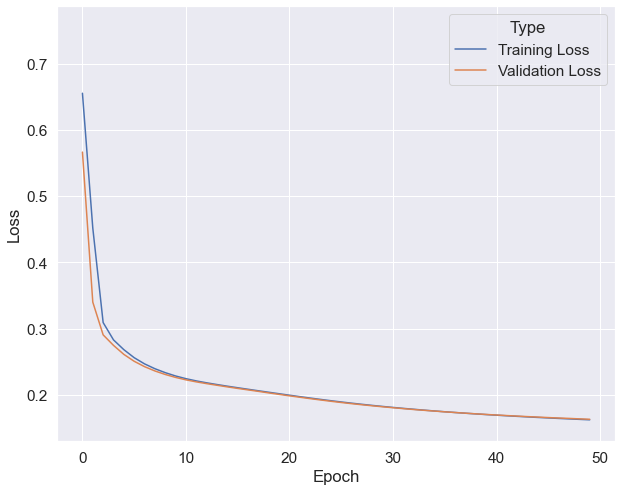

In [36]:
# Visualize the training and validation loss

losses = history.history['loss'] + history.history['val_loss']
types = ['Training Loss'] * len(history.history['loss']) + ['Validation Loss'] * len(history.history['val_loss'])
epoches = history.epoch + history.epoch
df_losses = pd.DataFrame({'Loss': losses, 'Epoch':epoches, 'Type': types})

plt.figure(figsize=(10, 8))
ax = sns.lineplot(data=df_losses, x='Epoch', y='Loss', hue='Type')
ax.set(ylim=(min(df_losses['Loss']) * 0.8, max(df_losses['Loss']) * 1.2))

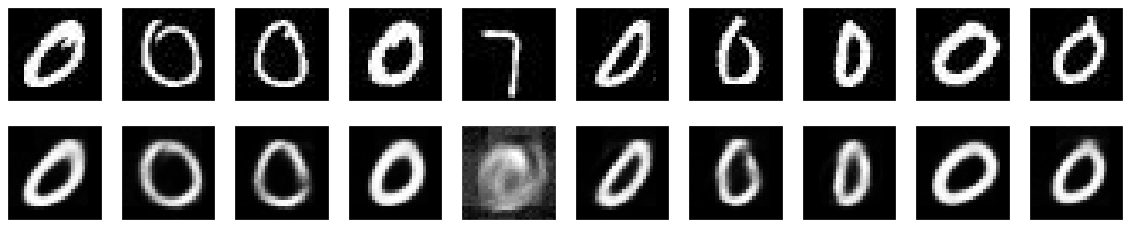

In [37]:
# Visualize the autoencoder predictions vs original images

shallow_decoded_imgs = shallow_autoencoder_2.predict(X_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(shallow_decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

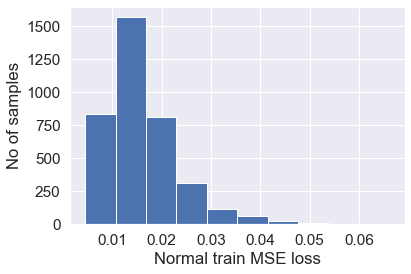

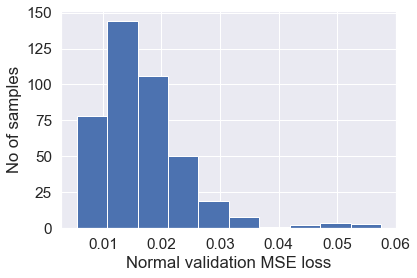

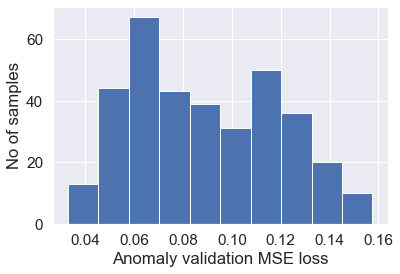

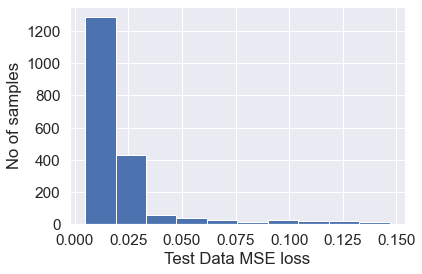

AUC of Test Data:  0.999392873904007


In [38]:
# Visualize the distribution of Mean Square Error

model = shallow_autoencoder_2


## MSE of Normal Training Data
errors_normal_train = []
x_normal_train_pred = model.predict(X_normal_train)
for i in range(len(X_normal_train)):
    errors_normal_train.append(np.mean((x_normal_train_pred[i] - X_normal_train[i])**2))


## MSE of Normal Validation Data
errors_normal_val = []
x_normal_val_pred = model.predict(X_normal_val)
for i in range(len(X_normal_val)):
    errors_normal_val.append(np.mean((x_normal_val_pred[i] - X_normal_val[i])**2))


## MSE of Anomaly Validation Data  
errors_anomaly_val = []
x_anomaly_val_pred = model.predict(X_anomaly_val)
for i in range(len(X_anomaly_val)):
    errors_anomaly_val.append(np.mean((x_anomaly_val_pred[i] - X_anomaly_val[i])**2))

    
## MSE of Normal & Anomaly Test Data
errors_test = []
x_test_pred = model.predict(X_test)
for i in range(len(X_test)):
    errors_test.append(np.mean((x_test_pred[i] - X_test[i])**2))


## Plot error distribution
plt.hist(errors_normal_train, bins=10)
plt.xlabel("Normal train MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_normal_val, bins=10)
plt.xlabel("Normal validation MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_anomaly_val, bins=10)
plt.xlabel("Anomaly validation MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_test, bins=10)
plt.xlabel("Test Data MSE loss")
plt.ylabel("No of samples")
plt.show()

from sklearn.metrics import roc_auc_score
print('AUC of Test Data: ', roc_auc_score(Y_test, errors_test))

errors_test_2 = errors_test

### Run 3:

In [39]:
shallow_autoencoder_3 = build_shallow_autoencoder(input_dim=784, encoding_dim=30)

In [40]:
# Start the training process
history = shallow_autoencoder_3.fit(X_normal_train, X_normal_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_normal_val, X_normal_val),
                callbacks=[es])

Epoch 1/50
15/15 [==============================] - 1s 37ms/step - loss: 0.6466 - val_loss: 0.5380
Epoch 2/50
15/15 [==============================] - 0s 23ms/step - loss: 0.4237 - val_loss: 0.3279
Epoch 3/50
15/15 [==============================] - 0s 22ms/step - loss: 0.3055 - val_loss: 0.2917
Epoch 4/50
15/15 [==============================] - 0s 23ms/step - loss: 0.2856 - val_loss: 0.2787
Epoch 5/50
15/15 [==============================] - 0s 21ms/step - loss: 0.2731 - val_loss: 0.2658
Epoch 6/50
15/15 [==============================] - 0s 21ms/step - loss: 0.2602 - val_loss: 0.2535
Epoch 7/50
15/15 [==============================] - 0s 20ms/step - loss: 0.2489 - val_loss: 0.2439
Epoch 8/50
15/15 [==============================] - 0s 23ms/step - loss: 0.2407 - val_loss: 0.2371
Epoch 9/50
15/15 [==============================] - 0s 24ms/step - loss: 0.2347 - val_loss: 0.2320
Epoch 10/50
15/15 [==============================] - 0s 23ms/step - loss: 0.2301 - val_loss: 0.2280
Epoch 11/

[(0.12937438488006592, 0.7759167909622192)]

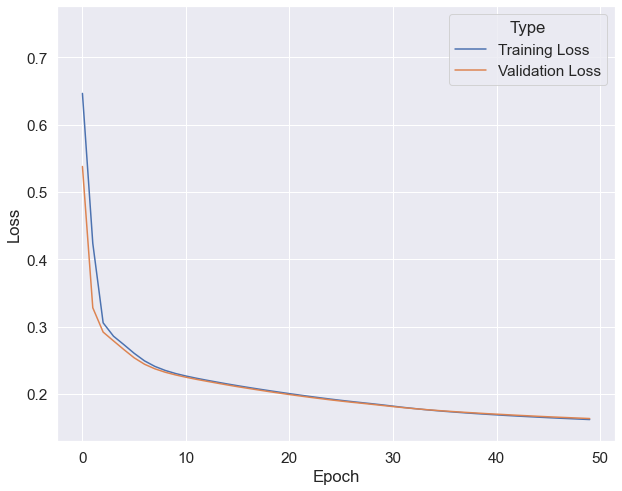

In [41]:
# Visualize the training and validation loss

losses = history.history['loss'] + history.history['val_loss']
types = ['Training Loss'] * len(history.history['loss']) + ['Validation Loss'] * len(history.history['val_loss'])
epoches = history.epoch + history.epoch
df_losses = pd.DataFrame({'Loss': losses, 'Epoch':epoches, 'Type': types})

plt.figure(figsize=(10, 8))
ax = sns.lineplot(data=df_losses, x='Epoch', y='Loss', hue='Type')
ax.set(ylim=(min(df_losses['Loss']) * 0.8, max(df_losses['Loss']) * 1.2))

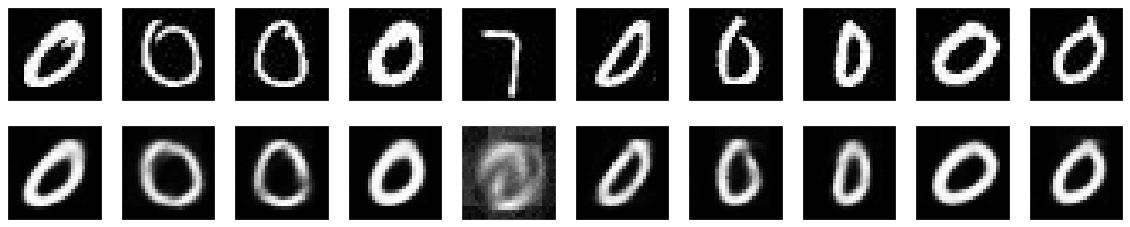

In [42]:
# Visualize the autoencoder predictions vs original images

shallow_decoded_imgs = shallow_autoencoder_3.predict(X_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(shallow_decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

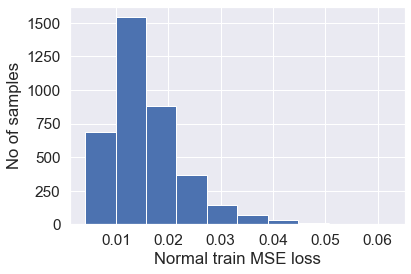

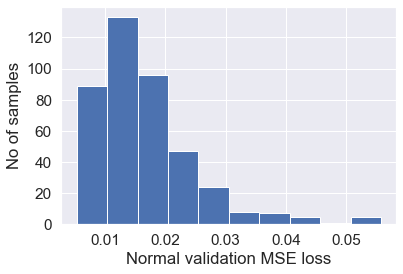

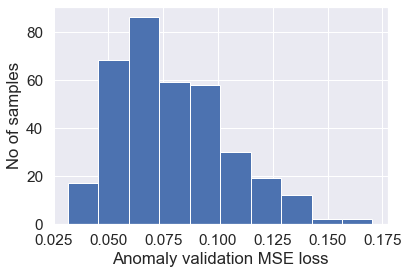

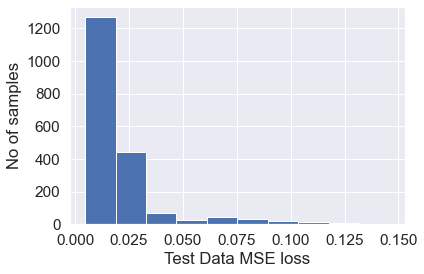

AUC of Test Data:  0.9991358696057033


In [43]:
# Visualize the distribution of Mean Square Error

model = shallow_autoencoder_3


## MSE of Normal Training Data
errors_normal_train = []
x_normal_train_pred = model.predict(X_normal_train)
for i in range(len(X_normal_train)):
    errors_normal_train.append(np.mean((x_normal_train_pred[i] - X_normal_train[i])**2))


## MSE of Normal Validation Data
errors_normal_val = []
x_normal_val_pred = model.predict(X_normal_val)
for i in range(len(X_normal_val)):
    errors_normal_val.append(np.mean((x_normal_val_pred[i] - X_normal_val[i])**2))


## MSE of Anomaly Validation Data  
errors_anomaly_val = []
x_anomaly_val_pred = model.predict(X_anomaly_val)
for i in range(len(X_anomaly_val)):
    errors_anomaly_val.append(np.mean((x_anomaly_val_pred[i] - X_anomaly_val[i])**2))

    
## MSE of Normal & Anomaly Test Data
errors_test = []
x_test_pred = model.predict(X_test)
for i in range(len(X_test)):
    errors_test.append(np.mean((x_test_pred[i] - X_test[i])**2))


## Plot error distribution
plt.hist(errors_normal_train, bins=10)
plt.xlabel("Normal train MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_normal_val, bins=10)
plt.xlabel("Normal validation MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_anomaly_val, bins=10)
plt.xlabel("Anomaly validation MSE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(errors_test, bins=10)
plt.xlabel("Test Data MSE loss")
plt.ylabel("No of samples")
plt.show()

from sklearn.metrics import roc_auc_score
print('AUC of Test Data: ', roc_auc_score(Y_test, errors_test))

errors_test_3 = errors_test

## 6. Quantify Model Performance using Average AUC-ROC Score of all three runs 
* Hence, we see that the average AUC-ROC score for the Shallow Autoencoder with L1 Regularization is 0.999006

In [47]:
avg_auc = np.mean([roc_auc_score(Y_test, errors_test_1), roc_auc_score(Y_test, errors_test_2), roc_auc_score(Y_test, errors_test_3)])
print('Average AUC ROC score across all 3 runs: ', avg_auc)

Average AUC ROC score across all 3 runs:  0.9990067466732221


## 7. Get best model of 3 randomly initialized weights to predict Kaggle Competition Test Data

* As we see that the AUC of errors of test data from prediction of the second run is the highest, we will use the second model initilized weights to predict kaggle test data

In [44]:
print('Model 1 Test AUC', roc_auc_score(Y_test, errors_test_1))
print('Model 2 Test AUC', roc_auc_score(Y_test, errors_test_2))
print('Model 3 Test AUC', roc_auc_score(Y_test, errors_test_3))

Model 1 Test AUC 0.9984914965099562
Model 2 Test AUC 0.999392873904007
Model 3 Test AUC 0.9991358696057033


In [46]:
model = shallow_autoencoder_2

error_kaggle = []
kaggle_pred = model.predict(kaggle_test)
for i in range(len(kaggle_test)):
    error_kaggle.append(np.mean((kaggle_pred[i] - kaggle_test[i])**2))
    
predict_output = pd.Series(error_kaggle, name='target')
predict_output = pd.concat([pd.Series(range(0,1070),name='id'), predict_output], axis=1)
# predict_output.to_csv("C:/Users/Asus/Desktop/Uni School Work/Year 4/Sem 1/BT4012/bt4012-in-class-competition/anomalydetection_autoencoder/l1_reg_autoencoder.csv", index=False)